## Get the Top 10 Most views videos of Youtube

In [ ]:
import os
import googleapiclient.discovery
import pandas as pd

# Replace 'YOUR_API_KEY' with your actual YouTube Data API key
API_KEY = 'YOUTUBE API'

def get_most_watched_videos(api_key, max_results=10):
    youtube = googleapiclient.discovery.build('youtube', 'v3', developerKey=api_key)

    # Get videos in the "most popular" category for the past 24 hours
    request = youtube.videos().list(
        part='snippet,statistics',  # Include 'statistics' to get viewCount and likeCount
        chart='mostPopular',
        regionCode='US',  # Replace with your desired region code
        maxResults=max_results
    )

    response = request.execute()

    # Extract the title, link, viewCount, and likeCount of each video
    videos = []
    for item in response['items']:
        title = item['snippet']['title']
        video_id = item['id']
        video_url = f'https://www.youtube.com/watch?v={video_id}'
        view_count = item['statistics']['viewCount']
        like_count = item['statistics']['likeCount']
        
        videos.append({
            'title': title,
            'url': video_url,
            'views': view_count,
            'likes': like_count,
            'id': video_id       
        })

    df = pd.DataFrame(videos)
    df.to_excel('MostWatched_Videos.xlsx')
    return videos

if __name__ == '__main__':
    most_watched_videos = get_most_watched_videos(API_KEY)

    # Display the most watched videos with view count and like count
    print("Most Watched Videos in the Past 24 Hours:")
    for idx, video in enumerate(most_watched_videos, start=1):
        print(f"{idx}. {video['title']}")
        print(f"   Link: {video['url']}")
        print(f"   Views: {video['views']}")
        print(f"   Likes: {video['likes']}\n")
        print(f"   Id: {video['id']}\n")





## From the above Top 10 list, Select any video ID to get All the comments (Without including replies)

In [31]:
from pyyoutube import Api
import os
import pandas as pd


API_KEY = YOUTUBE_API_KEY
api = Api(api_key=API_KEY)
VIDEO_ID = 'cen0rBKLuYE'

def get_all_comment_threads(api, video_id, per_page=100):
    threads = []
    token = None
    while True:
        response = api.get_comment_threads(
            video_id=video_id,
            count=per_page,
            page_token=token
        )
        threads.append(response)
        token = response.nextPageToken
        if not token:
            break
    return threads

threads = get_all_comment_threads(api, VIDEO_ID)
all_comments = [
    item.snippet.topLevelComment.snippet.textDisplay
    for t in threads for  item in t.items
]


coments_update = [
    item.snippet.topLevelComment.snippet.publishedAt
    for t in threads for  item in t.items
]

df_date = pd.DataFrame(list(zip(all_comments, coments_update )), columns = ['Message', 'DatesUpdated'])
df_date.to_excel('wolverine.xlsx')


## Perform the Sentimental Analysis Using VADAR

In [32]:
import pandas as pd
from nltk.sentiment.vader import SentimentIntensityAnalyzer


df_sentiment = pd.read_excel('wolverine.xlsx')
sid = SentimentIntensityAnalyzer()

df_sentiment['scores'] = df_sentiment['Message'].apply(lambda Message: sid.polarity_scores(Message))
df_sentiment['compound']  = df_sentiment['scores'].apply(lambda score_dict: score_dict['compound'])
df_sentiment['comp_score'] = df_sentiment['compound'].apply(lambda c: 'positive' if c >=0 else'negative')

#Positive comment percentage
positive = (len(df_sentiment[df_sentiment['comp_score'] == 'positive'])/len(df_sentiment))*100

#Negative comment percentage
negative = (len(df_sentiment[df_sentiment['comp_score'] == 'negative'])/len(df_sentiment))*100

print("Positive Comment Percentage: ", positive)
print("\n")
print("negative Comment Percentage: ", negative)


Positive Comment Percentage:  82.29450475751352


negative Comment Percentage:  17.70549524248648


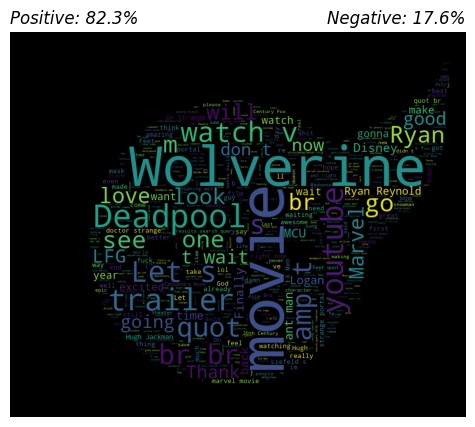

In [33]:
#Positive Coments Word Cloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import numpy as np 
import matplotlib.pyplot as plt
import PIL.Image 

pt = df_sentiment[df_sentiment['comp_score']=='positive']
python_mask = np.array(PIL.Image.open("DW.PNG"))

pstring = df_sentiment['Message'].str.cat(sep='  ')
wordcloud = WordCloud(stopwords=set(list(STOPWORDS)+["FUCKING","https","href","cen0rBKLuYE"]),mask=python_mask , background_color='black', max_words=550).generate(pstring)



plt.figure(figsize=(10,5))
plt.clf()
plt.imshow(wordcloud)
plt.axis('off')

plt.show()



In [34]:
df_sentiment.DatesUpdated=pd.to_datetime(df_sentiment.DatesUpdated)
plotdata =df_sentiment.groupby([pd.Grouper(key='DatesUpdated',freq='H'),df_sentiment.comp_score]).size().reset_index(name='count')


C:\Users\anil.karnam\AppData\Local\Temp\ipykernel_5060\3110638848.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  plotdata =df_sentiment.groupby([pd.Grouper(key='DatesUpdated',freq='H'),df_sentiment.comp_score]).size().reset_index(name='count')


In [35]:


plotdata.head(10)

,DatesUpdated,comp_score,count
0,2024-04-22 12:00:00+00:00,negative,69
1,2024-04-22 12:00:00+00:00,positive,678
2,2024-04-22 13:00:00+00:00,negative,1599
3,2024-04-22 13:00:00+00:00,positive,8141
4,2024-04-22 14:00:00+00:00,negative,1136
5,2024-04-22 14:00:00+00:00,positive,4836
6,2024-04-22 15:00:00+00:00,negative,768
7,2024-04-22 15:00:00+00:00,positive,3538
8,2024-04-22 16:00:00+00:00,negative,646
9,2024-04-22 16:00:00+00:00,positive,3058


In [36]:

plotdata2 = plotdata.pivot(index="DatesUpdated", columns="comp_score", values="count")

<Axes: xlabel='DatesUpdated'>

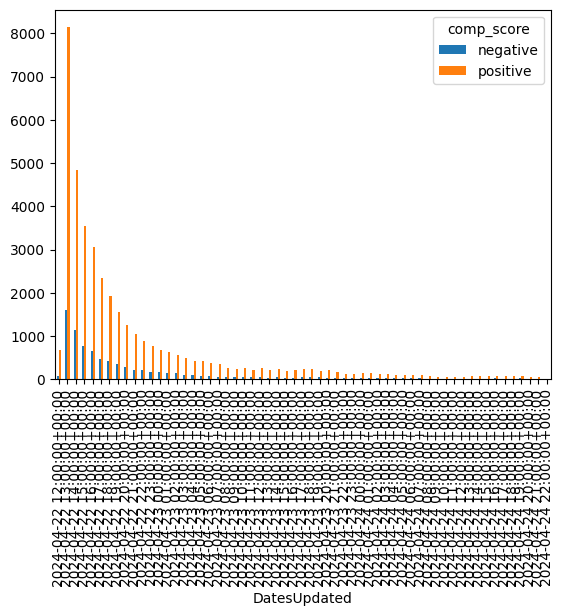

In [37]:
plotdata2.plot(kind='bar')